In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, roc_auc_score
)                           
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
#import pygeos
import rtree
import shapely
import pyproj
import geopandas
import seaborn as sns
from collections import Counter

In [12]:
#read in all the data, create copy of main df
df = pd.read_csv("NYC Accidents 2020 Cleanedish.csv")
coords = df[["LATITUDE", "LONGITUDE"]]
#boro_polys = geopandas.GeoDataFrame.from_file("borough.shp")

#get the coordinates into the right shape 
# coords["geometry"] = coords.apply(lambda row: shapely.geometry.Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
# #put coordinates into geodata frame
# boro_points = geopandas.GeoDataFrame(coords['geometry'], geometry="geometry")
# #makr sure coordinate systems match between coordinates and polygons
# boro_points.crs = boro_polys.crs
# #do the join
# boro_result = geopandas.tools.sjoin(boro_points, boro_polys, how="left") #this is same number of rows as df, so we can just add the column

# df["borough"] = boro_result["boro_name"]

In [13]:
#code for cleaning the vehicle type variable
def combine(lst):
    cleaned = [x for x in lst if x]
    return " --- ".join(cleaned)

car_types_df = df[["VEHICLE TYPE CODE 1",
                    "VEHICLE TYPE CODE 2",
                    "VEHICLE TYPE CODE 3",
                    "VEHICLE TYPE CODE 4",
                    "VEHICLE TYPE CODE 5"]]
car_types_df = car_types_df.fillna("")
car_types_lst = np.sort(car_types_df.values, axis = 1)
car_types_lst = list(map(combine, car_types_lst))

count = Counter()
for typ in car_types_lst: 
    count[typ] += 1
common = count.most_common(20)
type_set = set([k for k, v in common])
car_types_lst_topped = [x if x in type_set else "OTHER" for x in car_types_lst]

assert(len(set(car_types_lst_topped)) == 21)
df["VEHICLE TYPES"] = car_types_lst_topped
df = df.drop(["VEHICLE TYPE CODE 1",
                "VEHICLE TYPE CODE 2",
                "VEHICLE TYPE CODE 3",
                "VEHICLE TYPE CODE 4",
                "VEHICLE TYPE CODE 5"], axis = 1)
#nyc.head()

#do the one-hot encoding of the vehicle type variable
dummies_vehicles = pd.get_dummies(df["VEHICLE TYPES"])
df = df.join(dummies_vehicles)
df = df.rename(columns = {"": "VEHICLE TYPE MISSING"})

In [14]:
#One-Hot Encode the Contributing Factor variable
dummies_factors = pd.get_dummies(df["CONTRIBUTING FACTOR VEHICLE 1"])
df = df.join(dummies_factors)



In [19]:
#One-Hot Encode borough
dummies_borough = pd.get_dummies(df["BOROUGH"])
df = df.join(dummies_borough)

In [33]:
#make variable for month of accident
df["month"] = [df['CRASH DATE'][i].split("/")[1] for i in range(len(df)) ]
df["hour"] = [df["CRASH TIME"][i].split(":")[0] for i in range(len(df))]


#make the casualty variable
df["casualty"] = ((df["NUMBER OF PERSONS INJURED"] > 0) | (df["NUMBER OF PERSONS KILLED"]>0))*1

#create train-test split 
y = df["casualty"]
X = df.drop(["casualty"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [21]:
#baseline model - how many of our training set are not injured?
baseline = 1-(y_train.sum()/len(y_train))
print("Baseline model of classifying all accidents as no-injury has classification accuracy of " + str(round(baseline, 3)))

Baseline model of classifying all accidents as no-injury has classification accuracy of 0.726


In [22]:
df_vehicle_types = df[[
    'VEHICLE TYPE MISSING',
    'TAXI',
    'BUS --- SEDAN',
    'BOX TRUCK --- SUV',
    'SUV',
    'BIKE',
    'SEDAN',
    'SEDAN --- SUV --- SUV',
    'BIKE --- SEDAN',
    'SEDAN --- SEDAN --- SUV',
    'BIKE --- SUV',
    'PICK-UP TRUCK --- SUV',
    'SUV --- TAXI',
    'SEDAN --- SUV',
    'SEDAN --- SEDAN',
    'PICK-UP TRUCK --- SEDAN',
    'SEDAN --- TAXI',
    'SUV --- SUV',
    'SEDAN --- SEDAN --- SEDAN',
    'BOX TRUCK --- SEDAN',
    'OTHER',
    'casualty']]

In [23]:
df_vehicle_types_casulties = df_vehicle_types[df_vehicle_types['casualty'] == 1]
df_vehicle_types_non_casulties = df_vehicle_types[df_vehicle_types['casualty'] == 0]

In [24]:
accident_count_by_vehicle_types = [(a, b, c, d) for a, b, c, d in zip(
    df_vehicle_types.drop(['casualty'], axis = 1).columns, 
    df_vehicle_types.drop(['casualty'], axis = 1).values.sum(axis = 0), 
    df_vehicle_types_casulties.drop(['casualty'], axis = 1).values.sum(axis = 0),
    df_vehicle_types_non_casulties.drop(['casualty'], axis = 1).values.sum(axis = 0))]
accident_count_by_vehicle_types.sort(key = lambda x : x[1])
accident_count_by_vehicle_types_cols = [k for k, _, _, _ in accident_count_by_vehicle_types]
accident_count_by_vehicle_types_casulties = [v for _, _, v, _ in accident_count_by_vehicle_types]
accident_count_by_vehicle_types_non_casulties = [v for _, _, _, v in accident_count_by_vehicle_types]

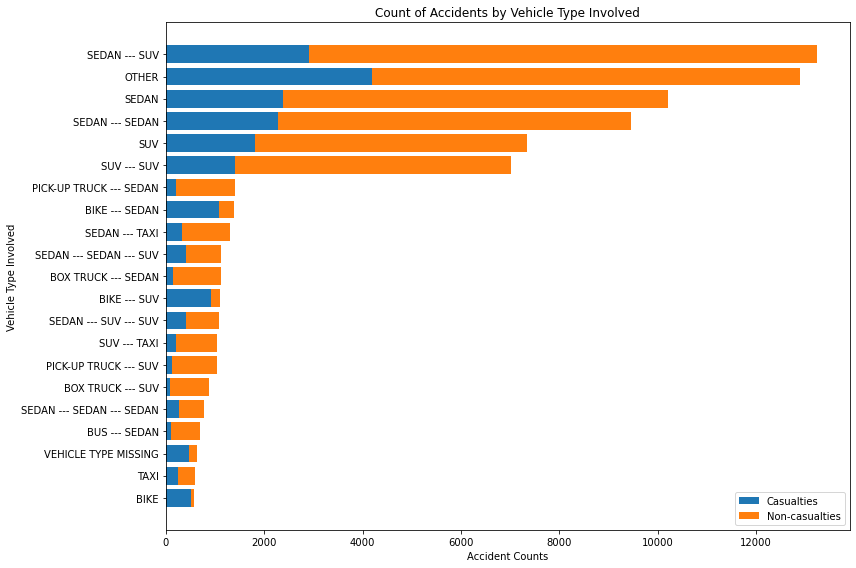

In [25]:
plt.figure(figsize = (12, 8))
plt.barh(accident_count_by_vehicle_types_cols, accident_count_by_vehicle_types_casulties, label = "Casualties")
plt.barh(accident_count_by_vehicle_types_cols, accident_count_by_vehicle_types_non_casulties, 
         left = accident_count_by_vehicle_types_casulties, label = "Non-casualties")
plt.xlabel("Accident Counts")
plt.ylabel("Vehicle Type Involved")
plt.legend()
plt.title("Count of Accidents by Vehicle Type Involved")
plt.tight_layout()
plt.savefig("vehicle_type.png", dpi = 300)
plt.show()

In [26]:
df_contributing_factors = dummies_factors
df_contributing_factors["casualty"] = df["casualty"]
df_contributing_factors_casulties = df_contributing_factors[df_contributing_factors['casualty'] == 1]
df_contributing_factors_non_casulties = df_contributing_factors[df_contributing_factors['casualty'] == 0]

In [27]:
accident_count_by_contributing_factors = [(a, b, c, d) for a, b, c, d in zip(
    df_contributing_factors.drop(['casualty'], axis = 1).columns, 
    df_contributing_factors.drop(['casualty'], axis = 1).values.sum(axis = 0), 
    df_contributing_factors_casulties.drop(['casualty'], axis = 1).values.sum(axis = 0),
    df_contributing_factors_non_casulties.drop(['casualty'], axis = 1).values.sum(axis = 0))]
accident_count_by_contributing_factors.sort(key = lambda x : x[1])
accident_count_by_contributing_factors_cols = [k for k, _, _, _ in accident_count_by_contributing_factors]
accident_count_by_contributing_factors_casulties = [v for _, _, v, _ in accident_count_by_contributing_factors]
accident_count_by_contributing_factors_non_casulties = [v for _, _, _, v in accident_count_by_contributing_factors]

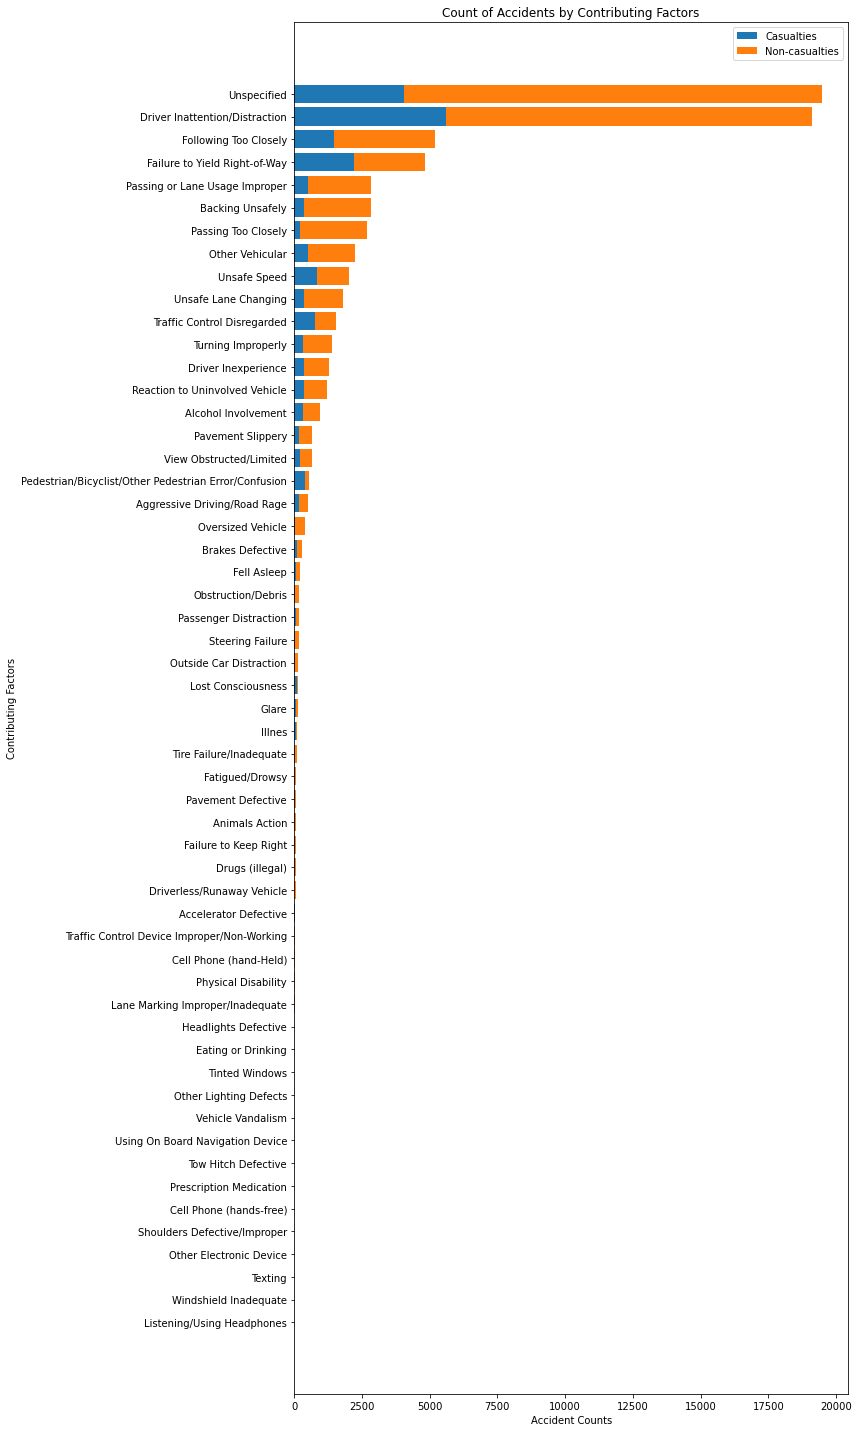

In [28]:
plt.figure(figsize = (12, 20))
plt.barh(accident_count_by_contributing_factors_cols, accident_count_by_contributing_factors_casulties, label = "Casualties")
plt.barh(accident_count_by_contributing_factors_cols, accident_count_by_contributing_factors_non_casulties, 
         left = accident_count_by_contributing_factors_casulties, label = "Non-casualties")
plt.xlabel("Accident Counts")
plt.ylabel("Contributing Factors")
plt.legend()
plt.title("Count of Accidents by Contributing Factors")
plt.tight_layout()
plt.savefig("contributing_factor.png", dpi = 300)
plt.show()

In [35]:
#prepare data for running logistic model - get list of all the covariates 
predictors = df["CONTRIBUTING FACTOR VEHICLE 1"].unique().tolist()
types = df["VEHICLE TYPES"].unique().tolist()
boroughs = df["BOROUGH"].unique().tolist()
#predictors = [INSERT LIST HERE]
for i in types:
  predictors.append(i)
for i in boroughs:
    predictors.append(i)
other_vars = ["month","hour"]
for i in other_vars:
  predictors.append(i)
predictors = [x for x in predictors if pd.isnull(x) == False]
predictors = [x for x in predictors if x != ""]
predictors = [x for x in predictors if x != "casualty"]
predictors

['Passing Too Closely',
 'Reaction to Uninvolved Vehicle',
 'Backing Unsafely',
 'Unsafe Speed',
 'Failure to Yield Right-of-Way',
 'Unspecified',
 'Unsafe Lane Changing',
 'Driver Inattention/Distraction',
 'Oversized Vehicle',
 'Pavement Slippery',
 'Following Too Closely',
 'Driver Inexperience',
 'Other Vehicular',
 'Failure to Keep Right',
 'Passing or Lane Usage Improper',
 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
 'Alcohol Involvement',
 'Fell Asleep',
 'Traffic Control Disregarded',
 'Animals Action',
 'Brakes Defective',
 'Glare',
 'Turning Improperly',
 'Obstruction/Debris',
 'Aggressive Driving/Road Rage',
 'Steering Failure',
 'Tire Failure/Inadequate',
 'Lost Consciousness',
 'View Obstructed/Limited',
 'Traffic Control Device Improper/Non-Working',
 'Illnes',
 'Pavement Defective',
 'Fatigued/Drowsy',
 'Tinted Windows',
 'Accelerator Defective',
 'Passenger Distraction',
 'Drugs (illegal)',
 'Outside Car Distraction',
 'Using On Board Navigation Device',
 

In [36]:
#CODE FOR RUNNING LOGISTIC CROSS-VALIDATION MODEL
logit = LogisticRegressionCV(penalty = "l2", max_iter=5000, cv=10).fit(X_train[predictors], y_train)

In [37]:
#get accuracy scores in train and test 
train_preds = logit.predict(X_train[predictors])
acc_train = accuracy_score(y_train, train_preds)
test_preds = logit.predict(X_test[predictors])
acc_test = accuracy_score(y_test, test_preds)
print("Accuracy score in train = ", str(round(acc_train, 3)) )
print("Accuracy score in test = ", str(round(acc_test, 3)) )

Accuracy score in train =  0.762
Accuracy score in test =  0.763


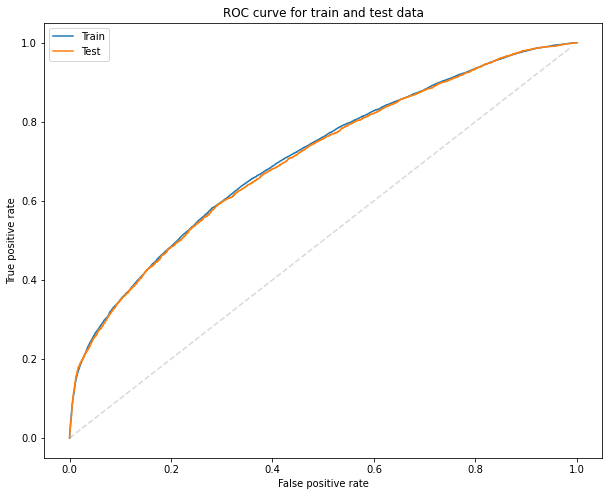

In [38]:
#CODE FOR CREATING ROC PLOT
#get ROCs for the training and test data
yhat_train = logit.predict_proba(X_train[predictors])[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, yhat_train)
yhat_test = logit.predict_proba(X_test[predictors])[:,1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test.values, yhat_test)

#write the plot 
plt.figure(figsize=(10,8))

x = np.arange(0,100)/100
plt.plot(x, x, "--", color = "gray", alpha = 0.3)
plt.plot(fpr_train, tpr_train, label = "Train")
plt.plot(fpr_test, tpr_test, label = "Test")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.title('ROC curve for train and test data')
plt.legend()
plt.show()